In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'dataset/table_AIH_2009_2024_CLEAN.csv', sep=';')

In [3]:
df.groupby(['mes','ano'], observed=False).agg({'partos_e_nascimentos_qtd': 'sum'}).reset_index()

,mes,ano,partos_e_nascimentos_qtd
0,1,2009,105424.0
1,1,2010,103943.0
2,1,2011,98951.0
3,1,2012,92914.0
4,1,2013,94223.0
...,...,...,...
177,12,2019,80365.0
178,12,2020,75730.0
179,12,2021,78142.0
180,12,2022,75175.0


In [4]:
df['data'] = list(map(lambda x,y: "{}-{}".format(x,y), df['ano'], df['mes']))

In [5]:
def convert_to_datetime(data):
    return datetime.strptime(data, format("%Y-%m"))

In [6]:
df['time'] = list(map(lambda x: convert_to_datetime(x), df['data']))

In [7]:
df_st = df.groupby(['time']).agg({'partos_e_nascimentos_qtd': 'sum',
                                  'partos_e_nascimentos_val':'sum',
                                  'cirurgias_obstetricas_qtd': 'sum',
                                  'cirurgias_obstetricas_val': 'sum'})

In [8]:
df_st = df_st['2009-01-01':'2023-12-01']

In [9]:
df_st.shape

(180, 4)

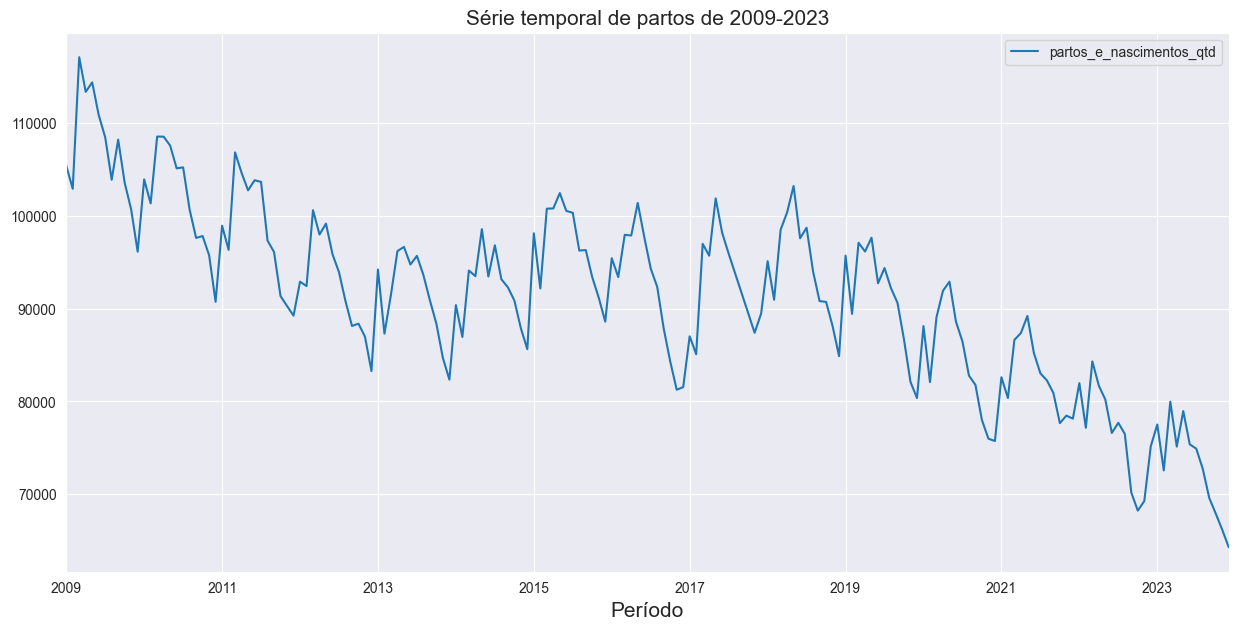

In [10]:
df_st['partos_e_nascimentos_qtd'].plot(figsize=(15,7), legend=True)
plt.xlabel('Período',size=15)
plt.title('Série temporal de partos de 2009-2023',size=15);

###### Como a série aparentemente possui sazonalidade então seria necessário aplicar a modelagem SARIMA (componente sazonal). O modelo SARIMA precisa da identificação de parâmetros autoregressivos p, d e q e, também, parâmetros de componentes sazonais P, D e Q.
###### Para eliminar as componentes sazonais será necessário eliminar a sazonalidade dos dados e identificar somente os parâmetros p, d e q com a metodologia Box-Jenkins.
###### Para iniciar a sazonalidade será exposta graficamente e depois será aplicada a decomposição da série temporal nas componentes tendência, sazonalidade e erros (resíduos). A decomposição será da forma aditiva e multiplicativa e no final a comparação das formas. Para essa decomposição será utilizado a biblioteca python statsmodels.

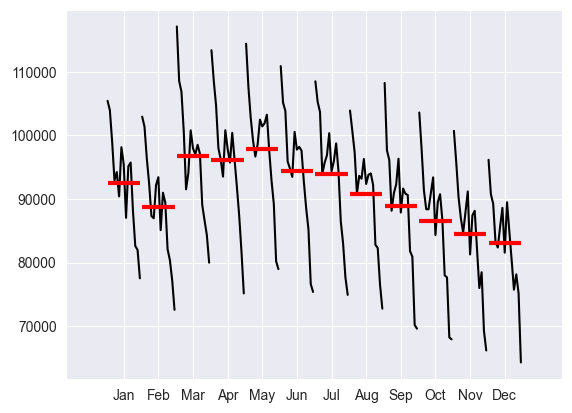

In [11]:
month_plot(df_st.partos_e_nascimentos_qtd)
plt.show()

###### Analisando graficamente é possível identificar o não alinhamento das linhas vermelhas, indicando sazonalidade nos dados.

##### Decomposição de série temporal
###### Uma série temporal com sazonalidade possui as componentes: tendência, sazonalidade e resíduos. 
###### Uma série multiplicativa é dada por Y = T * S * e, onde T é a tendência, S a sazonalidade e e o erro. Assim, podemos definir a série sem sazonalidade como Y/T = S * e.

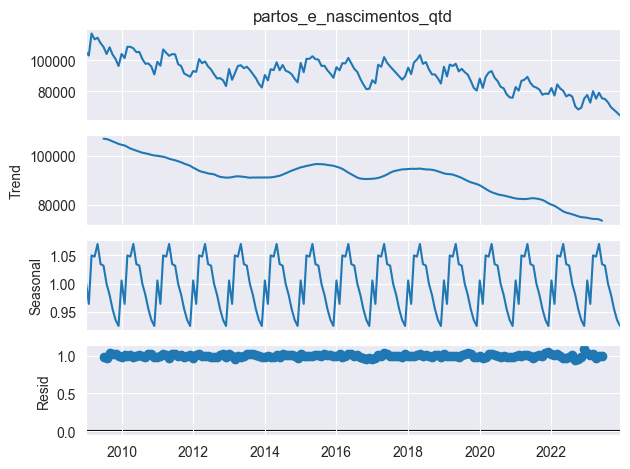

In [12]:
decomposicao_multi = seasonal_decompose(df_st['partos_e_nascimentos_qtd'], model='multiplicative', period=12)
decomposicao_multi.plot()
plt.show()

###### O primeiro gráfico é a série original onde a variável dependente é partos_e_nascimentos_qtd. O grafico mostra o número de partos por mês durante os anos 2009 a 2023. O Segundo gráfico é a componente tendência, o terceiro gráfico a componente sazonal e o último os erros (resíduos). 

##### Abaixo as séries de sazonalidade e de resíduos

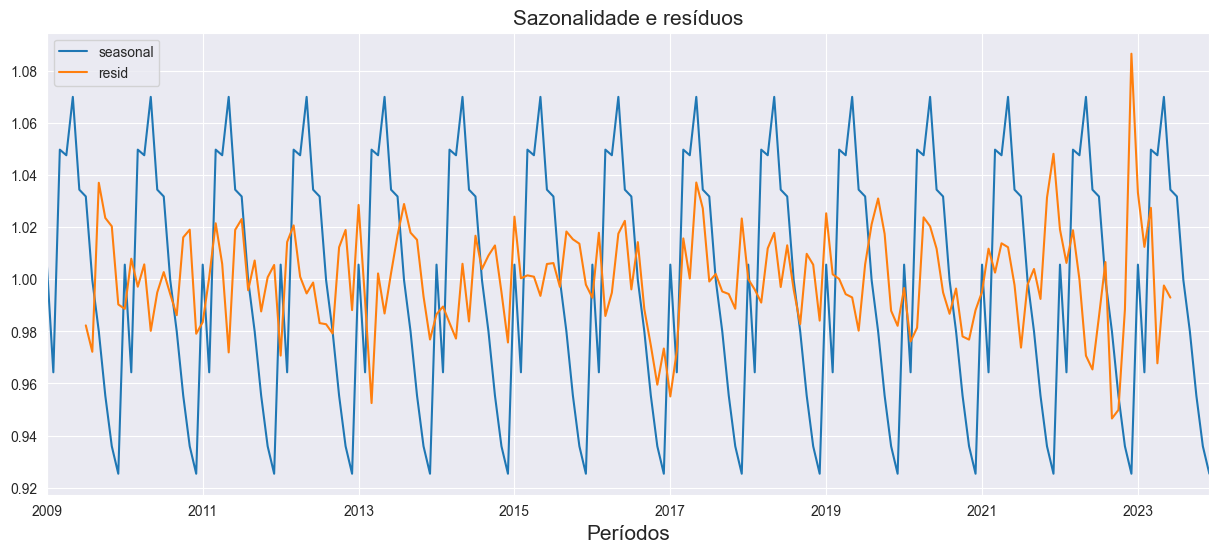

In [13]:
plt.figure(figsize=(15,6))
decomposicao_multi.seasonal.plot(legend=True)
decomposicao_multi.resid.plot(legend=True)
plt.xlabel('Períodos',size=15)
plt.title('Sazonalidade e resíduos',size=15);

Text(0.5, 1.0, 'Tendência')

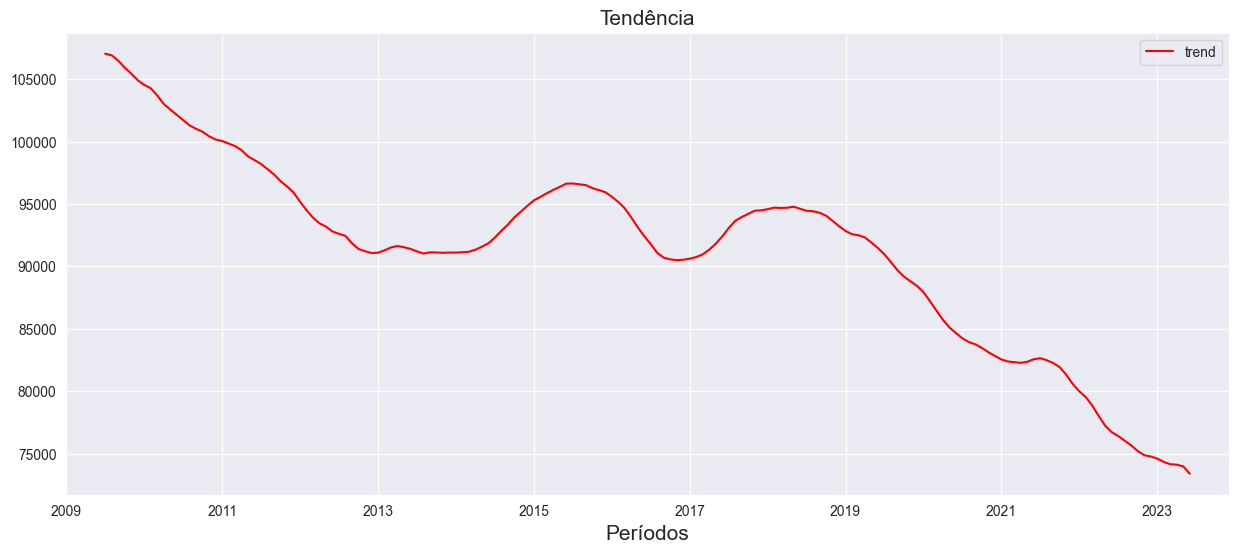

In [14]:
plt.figure(figsize=(15,6))
decomposicao_multi.trend.plot(legend=True, color='r')
plt.xlabel('Períodos',size=15)
plt.title('Tendência',size=15)

###### Vamos criar uma nova série a partir da multiplicação da componentes encontradas anteriormente. Como decompomos a série de forma multiplicativa, se multiplicarmos os componentes de erro e tendência, obteremos a série sem o componente sazonal, ou seja, dessazonalizada.

In [15]:
df_multi = (decomposicao_multi.trend * decomposicao_multi.resid)

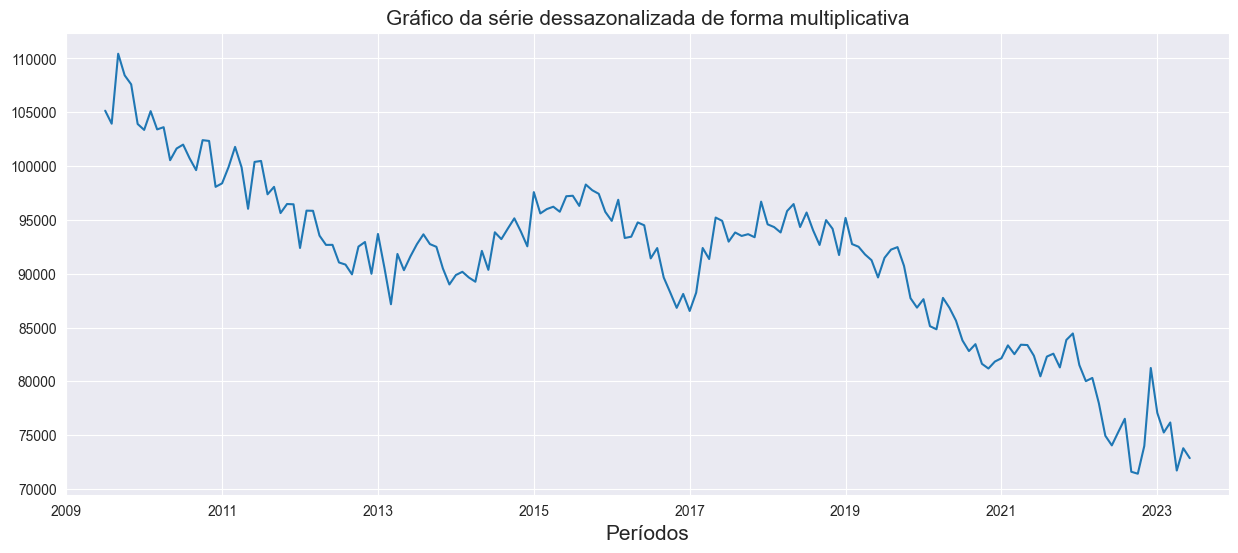

In [16]:
plt.figure(figsize=(15,6))
df_multi.plot()
plt.xlabel('Períodos',size=15)
plt.title('Gráfico da série dessazonalizada de forma multiplicativa',size=15);

##### A série não apresenta ciclos repetitivos (sazonalidade). Vamos adicionar uma nova coluna com a sazonalidade na série original.

In [17]:
df_st['sazonal'] = decomposicao_multi.seasonal

##### Agora vamos a adicionar uma coluna da série dessazonalizada na série original

In [18]:
df_st['sem_sazonal'] = df_st['partos_e_nascimentos_qtd'] / df_st['sazonal']

#### Plotaremos o resultado

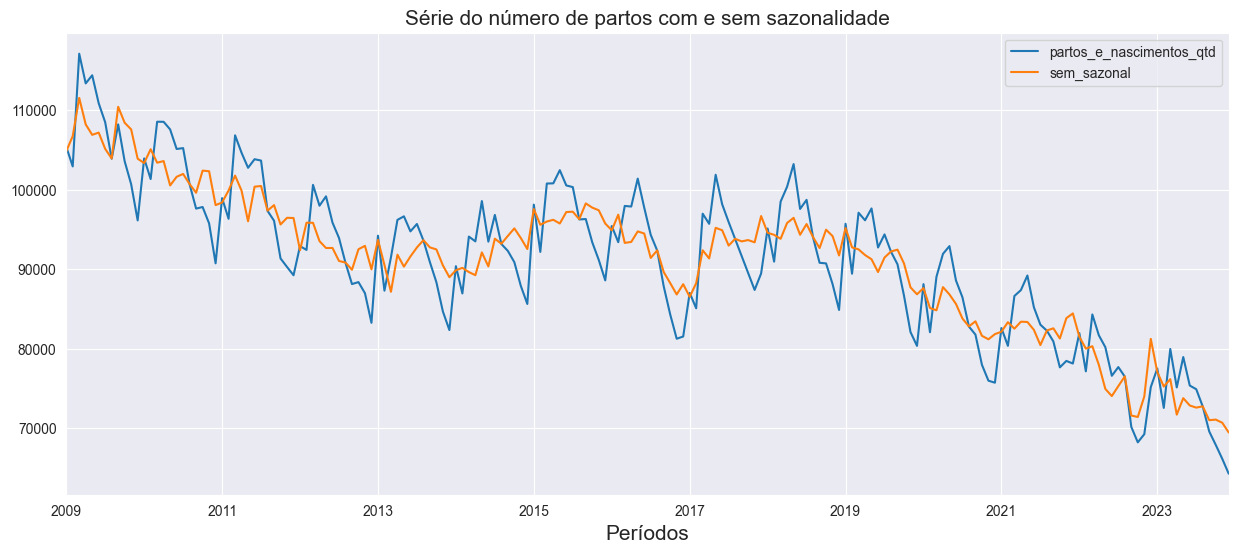

In [19]:
df_st[['partos_e_nascimentos_qtd','sem_sazonal']].plot(figsize=(15,6))
plt.xlabel('Períodos',size=15)
plt.title('Série do número de partos com e sem sazonalidade',size=15);

In [20]:
df_st[['partos_e_nascimentos_qtd', 'sazonal', 'sem_sazonal']]

,partos_e_nascimentos_qtd,sazonal,sem_sazonal
time,,,
2009-01-01,105424.0,1.005648,104831.887819
2009-02-01,102933.0,0.964290,106744.834170
2009-03-01,117114.0,1.049818,111556.468454
2009-04-01,113382.0,1.047655,108224.513544
2009-05-01,114401.0,1.070090,106907.825083
...,...,...,...
2023-08-01,72737.0,0.999678,72760.448426
2023-09-01,69596.0,0.980002,71016.190565
2023-10-01,67911.0,0.955328,71086.554470


##### Notamos os valores se repetindo ano a ano. Os valores para janeiro são os mesmos para cada ano, assim como para os outros meses.  

#### Decomposição aditica da série.
###### Uma série aditiva pode ser escrita da seguinte forma: Y = T + S + e. Onde T é a tendência, S a sazonalidade e e o erro. Assim, para uma série sem sazonalidade, temos: Y - S = Y + e.

In [21]:
decomposicao_adit = seasonal_decompose(df_st['partos_e_nascimentos_qtd'], model='aditive')

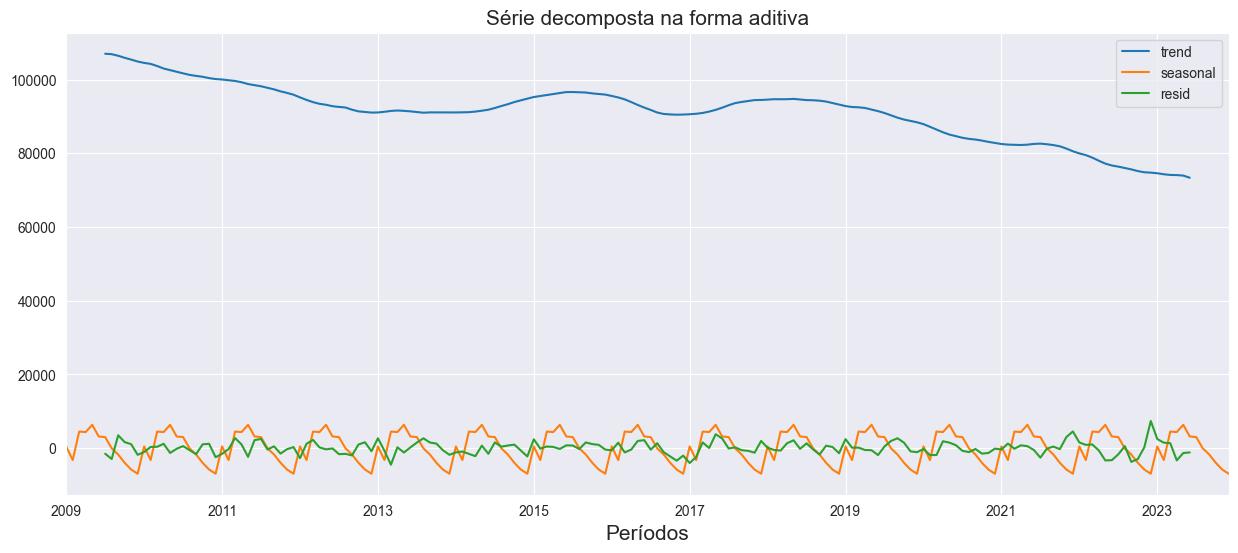

In [22]:
plt.figure(figsize=(15,6))
decomposicao_adit.trend.plot(legend=True)
decomposicao_adit.seasonal.plot(legend=True)
decomposicao_adit.resid.plot(legend=True)
plt.xlabel('Períodos',size=15)
plt.title('Série decomposta na forma aditiva',size=15)
plt.show()

In [23]:
df_st.columns

Index(['partos_e_nascimentos_qtd', 'partos_e_nascimentos_val',
       'cirurgias_obstetricas_qtd', 'cirurgias_obstetricas_val', 'sazonal',
       'sem_sazonal'],
      dtype='object')

In [24]:
df_st['sem_sazonal_a'] = df_st['partos_e_nascimentos_qtd'] - decomposicao_adit.seasonal

In [25]:
df_st['sazonal_a'] = decomposicao_adit.seasonal

In [26]:
df_st[['partos_e_nascimentos_qtd', 'sazonal_a', 'sem_sazonal_a']]

,partos_e_nascimentos_qtd,sazonal_a,sem_sazonal_a
time,,,
2009-01-01,105424.0,454.329365,104969.670635
2009-02-01,102933.0,-3240.617063,106173.617063
2009-03-01,117114.0,4491.897817,112622.102183
2009-04-01,113382.0,4357.472222,109024.527778
2009-05-01,114401.0,6328.903770,108072.096230
...,...,...,...
2023-08-01,72737.0,-59.450397,72796.450397
2023-09-01,69596.0,-1738.093254,71334.093254
2023-10-01,67911.0,-3980.500992,71891.500992


##### A sazonalidade na forma aditiva possui valores negativos diferentemente da forma multiplicativa

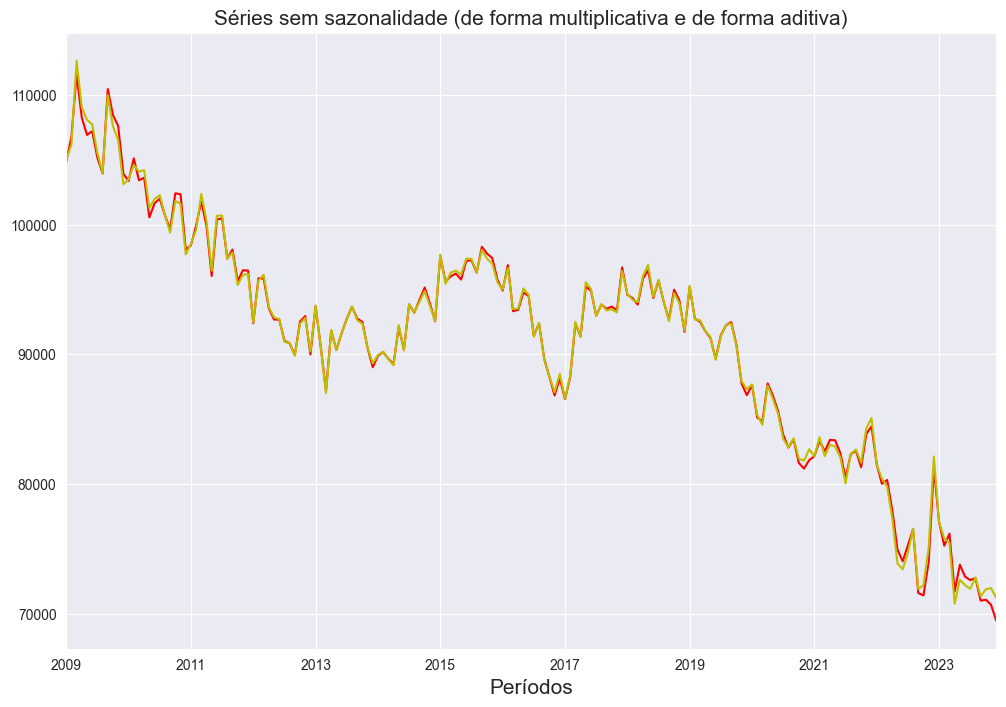

In [27]:
df_st['sem_sazonal'].plot(figsize=(12,8),color='r')
df_st['sem_sazonal_a'].plot(color='y')
plt.xlabel('Períodos',size=15)
plt.title('Séries sem sazonalidade (de forma multiplicativa e de forma aditiva)',size=15);

#Na cor amarela temos a série sem a sazonalidade na forma aditiva   

###### Box-Jenkins: Etapa de identificação

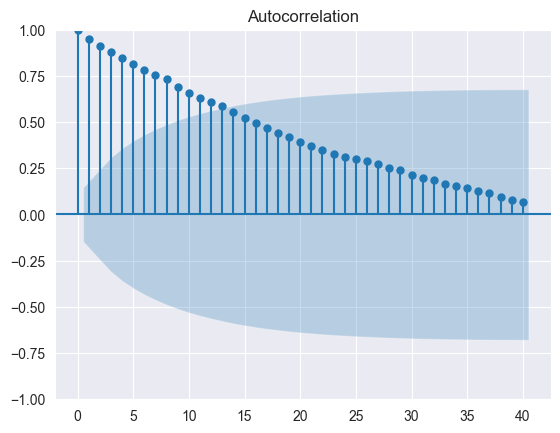

In [28]:
plot_acf(df_st['sem_sazonal'], lags =40)
plt.show()

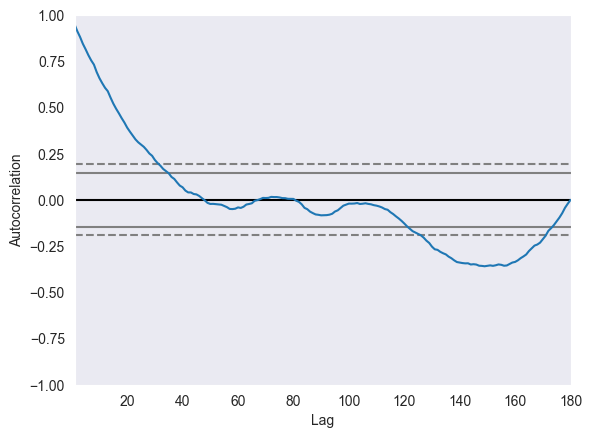

In [29]:
autocorrelation_plot(df_st['sem_sazonal'])
plt.show()

#### Diferenciação: teste ADF

## Hipótese Nula (H₀): A série é não estacionária
## Hipótese alternativa (H₁): A série é estacionária
## Valor crítico p-value: 0.05


In [44]:
# Função para testar estacionariedade com o teste ADF
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05  # Retorna True se a série é estacionária (p-value <= 0.05)

Teste ADF na série original:
ADF Statistic: -0.517565889904516
p-value: 0.8885428082064443
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
ADF Statistic: -0.517565889904516
p-value: 0.8885428082064443
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
1


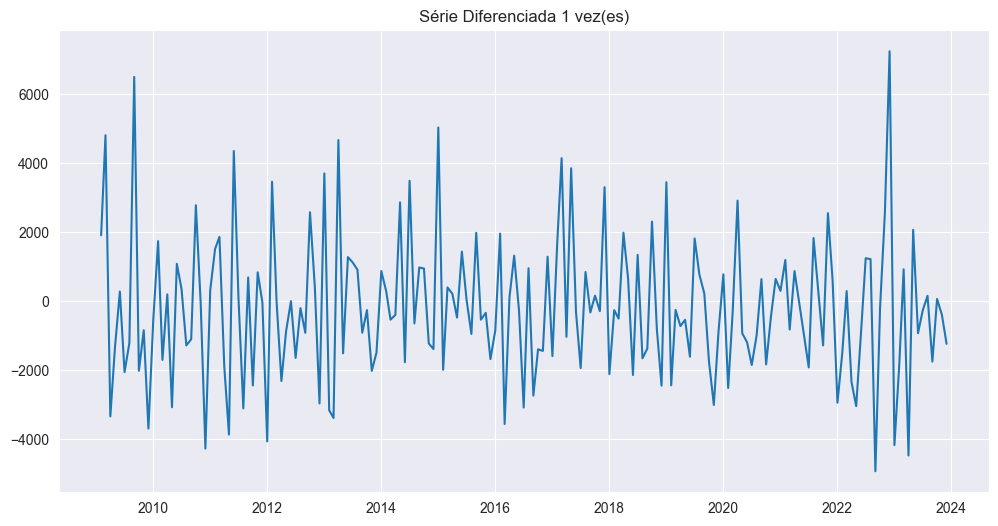

ADF Statistic: -14.236853646404649
p-value: 1.5618862408487662e-26
Critical Values:
   1%: -3.467845319799907
   5%: -2.878011745497439
   10%: -2.575551186759871
A série se tornou estacionária após 1 diferenciações.


In [90]:
# Testar estacionariedade da série original
print('Teste ADF na série original:')
adf_test(df_st['sem_sazonal'])

# Diferenciação até a série se tornar estacionária
d = 0
m = 1
serie = df_st['sem_sazonal']
while not adf_test(serie):
    d += 1
    print(d)
    serie = serie.diff(m).dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(serie)
    plt.title(f'Série Diferenciada {d} vez(es)')
    plt.show()

print(f'A série se tornou estacionária após {d} diferenciações.')

##### O teste falhou para o teste com a série original sem_sazonalidade. A hipotése alternativa foi rejeitada, então aceitasse a hipótese nula que a série não é estacionária. Com a primeira diferenciação o p-value foi menor que o valo crítico, assim rejeitasse a hipótose nula, enquanto que a hipótese alternativa é aceita. Dessa forma, a série é estacionária, logo a ordem d é igual a 1 que representa uma única diferenciação.

In [91]:
from statsmodels.tsa.statespace.tools import diff
df_st['sem_sazon_diff1'] = diff(df_st['sem_sazonal'], k_diff=1)

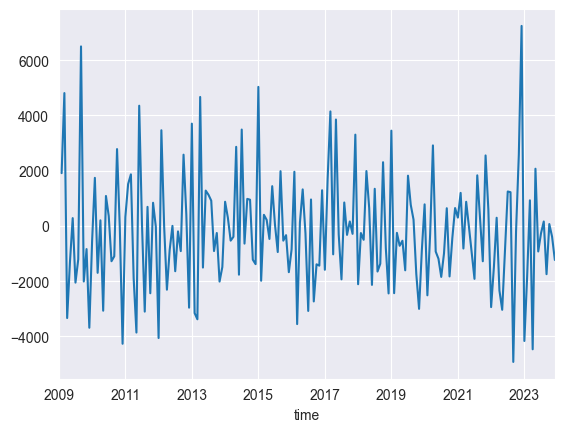

In [92]:
df_st['sem_sazon_diff1'].plot()
plt.show()

#### Ordens p e q.
##### Para definir as ordens p e q nós usaremos as funções de autocorrelação e de autocorrelação parcial, que, como já dito, são gráficos que mostram a correlação da observação atual com suas defasagens.

##### A função de autocorrelação (ACF) nos dará as possíveis ordens do componente de médias móveis (MA) e a função de autocorrelação parcial nos dará as possíveis ordens do compoenente autorregressivo (AR). Mas para isso iremos plotar a ACF e PACF da série diferenciada e observar as defasagens que são mais estatisticamente significativas, ou seja, as que estiverem fora do intervalo de confiança gerado nos gráficos

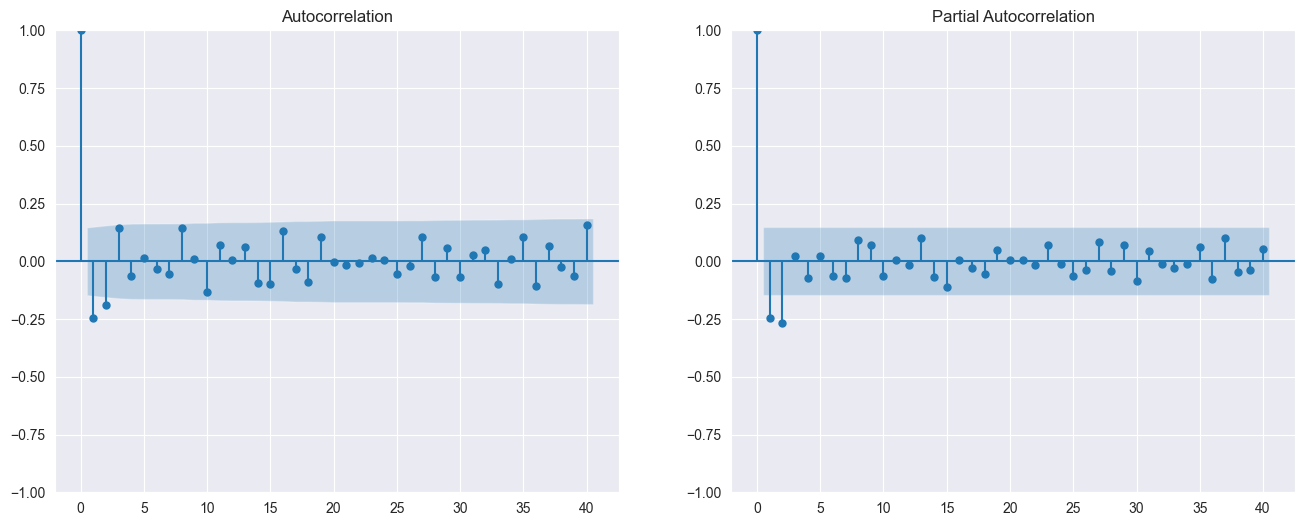

In [94]:
# Plotar ACF e PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_st['sem_sazonal'].diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_st['sem_sazonal'].diff().dropna(), lags=40, ax=ax[1])
plt.show()

##### Observando o gráfico ACF as defasagens mais significativas são 1, 2 e 3. Enquanto que para o gráfico PACF as defasagens mais significativas são 1, 2 e 3.

##### Dessa forma as ordens de q são 0, 1 e 2; e para p são 0, 1 e 2.

#### Estimação: Com as os parâmetros p, d e q definidos, então podemos estimar o melhor modelos ARIMA com as combinações de parâmetros encontrados.

#### ARIMA (p, d, q), onde p = [0, 1, 2], d = 1 e q = [0, 1, 2]. Assim temos as combinações ARIMA:

#### ARIMA(0,1,0)
#### ARIMA(0,1,1)
#### ARIMA(0,1,2)
#### ARIMA(1,1,0)
#### ARIMA(1,1,1)
#### ARIMA(1,1,2)
#### ARIMA(2,1,0)
#### ARIMA(2,1,1)
#### ARIMA(2,1,2)

#### Temos, então, as 6 possibilidades como modelos candidatos. Vamos testar cada um desses modelos e escolheremos aquele que possui o menor critério de informação. Os critérios de informação servem como forma de penalizar o modelo mais ampliado. O critério mais usado é o Akaike Information Criteria (AIC) ou Critério de Informação de Akaike (BIC).

In [95]:
import itertools

q=[0, 1, 2]
p=[0,1, 2]
d=[1]
#vamos criar as combinações com as ordens escolhidas
pdq=list(itertools.product(p,d,q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [123]:
#Vamos criar um loop for para testar todas as possibilidades de modelos
for param in pdq:
    modelo_arima = ARIMA(df_st['sem_sazonal'], order=param)
    modelo_arima_fit = modelo_arima.fit()
    print('ARIMA',param,'-', 'AIC do modelo:',modelo_arima_fit.aic,'-','BIC do modelo:', modelo_arima_fit.bic,
          '-','HQIC do modelo:', modelo_arima_fit.hqic)

ARIMA (0, 1, 0) - AIC do modelo: 3247.0709905523468 - BIC do modelo: 3250.2583763581874 - HQIC do modelo: 3248.363450296312
ARIMA (0, 1, 1) - AIC do modelo: 3250.074439548404 - BIC do modelo: 3256.4492111600853 - HQIC do modelo: 3252.6593590363345
ARIMA (0, 1, 2) - AIC do modelo: 3251.3100890467267 - BIC do modelo: 3260.872246464249 - HQIC do modelo: 3255.1874682786224
ARIMA (1, 1, 0) - AIC do modelo: 3249.3366162325183 - BIC do modelo: 3255.7113878441996 - HQIC do modelo: 3251.921535720449
ARIMA (1, 1, 1) - AIC do modelo: 3252.0440000342414 - BIC do modelo: 3261.606157451764 - HQIC do modelo: 3255.921379266137
ARIMA (1, 1, 2) - AIC do modelo: 3253.7962849523947 - BIC do modelo: 3266.545828175758 - HQIC do modelo: 3258.9661239282555
ARIMA (2, 1, 0) - AIC do modelo: 3251.048719524971 - BIC do modelo: 3260.6108769424936 - HQIC do modelo: 3254.926098756867
ARIMA (2, 1, 1) - AIC do modelo: 3252.6255371126417 - BIC do modelo: 3265.375080336005 - HQIC do modelo: 3257.7953760885025
ARIMA (2, 

##### O modelo com menor AIC foi o ARIMA(0, 1 ,0)

In [133]:
model = auto_arima(df_st['partos_e_nascimentos_qtd'],
                   d=2, #max_d=2, test = 'adf',
                   start_p=0, max_p=6,
                   start_q=0, max_q=6,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True,
                   seasonal=True,
                   m=12,
                   start_P=0, max_P=2,
                   start_Q=0, max_Q=2,
                   D=2
                   )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=3207.016, Time=0.03 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=3102.884, Time=0.52 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=3157.079, Time=0.05 sec
 ARIMA(1,2,0)(2,2,0)[12]             : AIC=3090.363, Time=0.43 sec
 ARIMA(1,2,0)(2,2,1)[12]             : AIC=3046.857, Time=0.84 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(1,2,0)(2,2,2)[12]             : AIC=3045.369, Time=0.95 sec
 ARIMA(1,2,0)(1,2,2)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,2,0)(2,2,2)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(2,2,0)(2,2,2)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(1,2,1)(2,2,2)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(0,2,1)(2,2,2)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(2,2,1)(2,2,2)[12]             : AIC=2979.792, Time=2.46 sec
 ARIMA(2,2,1)(1,2,2)[12]             : AIC=inf, Time=2

In [134]:
model.aic()

2979.7917190775534

#### Análise de resíduos

##### Essa etapa é crucial para a modelagem Box-Jenkins, pois se os resíduos (erros) do modelo escolhido não fore normalmente distribuídos não poderemos seguir para a etapa de previsão. Dizer que os erros são normais é o mesmo que dizer que esses erros são um ruído branco, ou seja, tem média 0 e variância constante. Os erros se comportando dessa forma garante que o modelo está captando bem as variações da série e que não há nenhum tipo de informação relevante para o comportamento da série temporal que não foi captada pela modelagem.

##### Teste de normalidade: O teste de Jarque-Bera tem como hipótese nula a normalidade. Assim, se o p-valor for menor do que 5% ,então o autor rejeita a normalidade. Já se p>0,05, aceita-se a normalidade.

##### Vamos treinar todos os 6 modelos anteriores treinados.

In [118]:
arima = []
for ordem in pdq:
    arima.append(SARIMAX(df_st['partos_e_nascimentos_qtd'], order=ordem, seasonal_order=(1, 1, 2, 12)).fit())

In [119]:
from statsmodels.stats.stattools import jarque_bera
for a in arima:
    print(' '*254)
    test = jarque_bera(a.resid)
    print('Estatística Jarque-Bera :', test[0])
    print('P-valor :', test[1])
    print('Assimetria :', test[2])
    print('Curtose :',test[3])

                                                                                                                                                                                                                                                              
Estatística Jarque-Bera : 52504.8314527183
P-valor : 0.0
Assimetria : 4.687580545201161
Curtose : 86.14295248681502
                                                                                                                                                                                                                                                              
Estatística Jarque-Bera : 52209.933496864876
P-valor : 0.0
Assimetria : 4.598610536882263
Curtose : 85.92608510456135
                                                                                                                                                                                                                                                              
E

In [120]:
for a in arima:
    print(a.summary())

                                        SARIMAX Results                                        
Dep. Variable:                partos_e_nascimentos_qtd   No. Observations:                  180
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -1553.728
Date:                                 Sun, 23 Jun 2024   AIC                           3115.455
Time:                                         21:50:50   BIC                           3127.927
Sample:                                     01-01-2009   HQIC                          3120.517
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5507      0.071      7.808      0.000       0.412       0

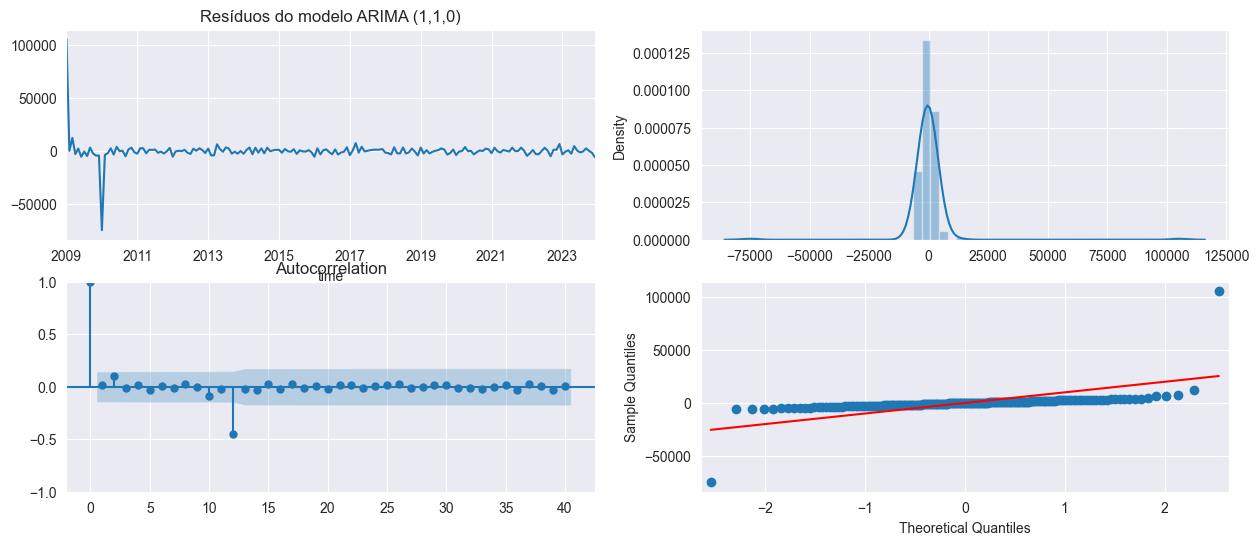

In [122]:
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(2,2,figsize=(15,6))
arima[-1].resid.plot(title="Resíduos do modelo ARIMA (1,1,0)", ax=ax[0][0])
sns.distplot(arima[-1].resid,ax=ax[0][1])
#residuals.plot(kind='kde', title='Distribuição dos resíduos', ax=ax[0][1])
plot_acf(arima[-1].resid,lags=40, ax=ax[1][0])
qqplot(arima[-1].resid,line='s', ax=ax[1][1]);